# Fire Spread Regression Summary (Condensed)

Quick read of the aggregated GOES + RTMA regression results.


## Variable meanings

- **Air temperature** = RTMA temperature
- **Wind speed** = RTMA wind speed
- **Wind direction** = RTMA wind direction
- **Specific humidity** = RTMA specific humidity
- **Hourly precipitation** = RTMA hourly precipitation
- **Wind alignment toward neighbor** = wind projected in the direction from the burning cell to the neighbor
- **Current fire confidence** = fire confidence at the same cell and time
- **Center‑cell fire confidence** = fire confidence at the burning cell (spread model)
- **Neighbor‑cell fire confidence** = fire confidence at the neighbor cell (pre‑ignite)


## Summary

- Data: GOES hourly fire confidence (~2 km) + RTMA hourly meteorology
- Models: logistic regression for **Spread** (neighbor ignites) and **Continue** (cell stays burning)
- Performance: AUC ≈ 0.64 for both models (modest signal)


In [17]:
from pathlib import Path

# Optional: set this if you are not running from the repo root.
# Example:
# REPORT_PATH = "/Users/seanmay/Desktop/Current Projects/GOFER/data/multi_fire/aggregate_regression_report.json"
REPORT_PATH = None

print("cwd:", Path.cwd())


cwd: /Users/seanmay/Desktop/Current Projects/GOFER/docs


In [18]:
import json
from pathlib import Path

REPORT_PATH = globals().get("REPORT_PATH", None)

def find_report_path():
    if REPORT_PATH:
        p = Path(REPORT_PATH).expanduser()
        if p.exists():
            return p
        raise FileNotFoundError(f"REPORT_PATH not found: {p}")

    candidates = []
    cwd = Path.cwd()
    candidates.append(cwd / "data/multi_fire/aggregate_regression_report.json")
    for parent in [cwd] + list(cwd.parents):
        candidates.append(parent / "data/multi_fire/aggregate_regression_report.json")

    for c in candidates:
        if c.exists():
            return c

    raise FileNotFoundError(
        "Could not find aggregate_regression_report.json. "
        "Run this notebook from the repo root or set REPORT_PATH."
    )

report_path = find_report_path()
report = json.loads(report_path.read_text())

print("Using report:", report_path)


Using report: /Users/seanmay/Desktop/Current Projects/GOFER/data/multi_fire/aggregate_regression_report.json


In [19]:
import pandas as pd

rows = []
for name in ["spread", "continue"]:
    s = report[name]
    rows.append({
        "model": name,
        "samples": s["samples"],
        "positives": s["positives"],
        "positive_rate": s["positives"] / s["samples"],
        "auc": s["auc"],
        "intercept": s["intercept"],
    })

df = pd.DataFrame(rows)
df


,model,samples,positives,positive_rate,auc,intercept
0,spread,425482,36991,0.086939,0.63719,-2.445437
1,continue,161621,124829,0.772356,0.64071,1.292427


## Coefficients (top features)


In [20]:
import math
import pandas as pd

label_map = {
    "TMP": "Air temperature",
    "WIND": "Wind speed",
    "WDIR": "Wind direction",
    "SPFH": "Specific humidity",
    "ACPC01": "Hourly precipitation",
    "wind_dot": "Wind alignment toward neighbor",
    "conf_center": "Center-cell fire confidence",
    "conf_neighbor": "Neighbor-cell fire confidence",
    "conf_t": "Current fire confidence",
}


def coef_table(section, top_n=8):
    rows = []
    for feat, coef in section["coefficients"].items():
        rows.append({
            "feature": label_map.get(feat, feat),
            "coef": coef,
            "odds_ratio": math.exp(coef),
            "abs_coef": abs(coef),
        })
    df = pd.DataFrame(rows).sort_values("abs_coef", ascending=False)
    return df.head(top_n).drop(columns=["abs_coef"])

coef_table(report["spread"], top_n=8)


,feature,coef,odds_ratio
0,Air temperature,0.465657,1.593061
2,Specific humidity,-0.260898,0.770360
4,Wind alignment toward neighbor,0.158452,1.171696
5,Center-cell fire confidence,0.127766,1.136287
1,Wind speed,0.035941,1.036594
3,Hourly precipitation,-0.029755,0.970683
6,Neighbor-cell fire confidence,0.000000,1.000000


In [21]:
coef_table(report["continue"], top_n=8)


,feature,coef,odds_ratio
4,Current fire confidence,0.469778,1.599639
2,Specific humidity,-0.252489,0.776865
0,Air temperature,0.132534,1.141718
1,Wind speed,0.101674,1.107022
3,Hourly precipitation,-0.009785,0.990263


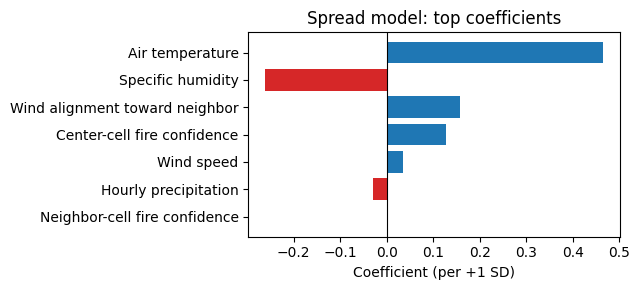

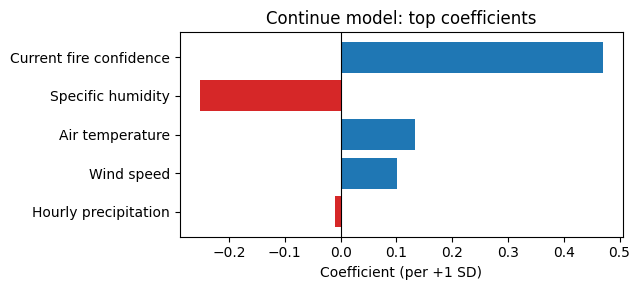

In [22]:
import matplotlib.pyplot as plt


def plot_coefs(section, title):
    rows = []
    for feat, coef in section["coefficients"].items():
        rows.append((label_map.get(feat, feat), coef))
    rows.sort(key=lambda x: abs(x[1]), reverse=True)
    rows = rows[:8]

    labels = [r[0] for r in rows][::-1]
    coefs = [r[1] for r in rows][::-1]
    colors = ["#1f77b4" if c >= 0 else "#d62728" for c in coefs]

    plt.figure(figsize=(6.5, 3.0))
    plt.barh(labels, coefs, color=colors)
    plt.axvline(0, color="black", linewidth=0.8)
    plt.title(title)
    plt.xlabel("Coefficient (per +1 SD)")
    plt.tight_layout()
    plt.show()

plot_coefs(report["spread"], "Spread model: top coefficients")
plot_coefs(report["continue"], "Continue model: top coefficients")


## Key takeaways

**Spread**
- Air temperature and wind alignment toward neighbor are the strongest positive drivers.
- Higher specific humidity suppresses spread.
- Center‑cell fire confidence boosts spread probability.

**Continue**
- Current fire confidence dominates persistence.
- Higher specific humidity reduces persistence; air temperature and wind speed help modestly.

**Overall**
- Signal is real but modest (AUC ~0.64). Non‑linear effects and fuel/terrain likely explain most remaining variance.


## Appendix:

**Constraints:**
- GOES is ~2 km and is a confidence signal, not a flame front.
- RTMA is a gridded analysis; local bias can remain.
- Hourly resolution only.
- No fuel/topography in the model.

**Improvements:**
- Add fuels + terrain (LANDFIRE, slope/aspect).
- Add **pre-fire fuel amounts** as a static feature layer.
- Add lagged meteorology and cumulative precip.
- Use wind components + gusts.
- Try non‑linear models (GAM/GBM) and spatial effects.
